## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.
4. Сравните результаты обучения на эквивалентном числе эпох.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Обучите CNN (самописная) на CIFAR-100.

In [3]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [4]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [5]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [7]:
classes = ['mammalsbeaver',
 'dolphin',
 'otter',
 'seal',
 'whale',
 'aquariumfish',
 'flatfish',
 'ray',
 'shark',
 'trout',
 'orchids',
 'poppies',
 'roses',
 'sunflowers',
 'tulips',
 'containersbottles',
 'bowls',
 'cans',
 'cups',
 'plates',
 'apples',
 'mushrooms',
 'oranges',
 'pears',
 'sweetpeppers',
 'clock',
 'computerkeyboard',
 'lamp',
 'telephone',
 'television',
 'furniturebed',
 'chair',
 'couch',
 'table',
 'wardrobe',
 'bee',
 'beetle',
 'butterfly',
 'caterpillar',
 'cockroach',
 'bear',
 'leopard',
 'lion',
 'tiger',
 'wolf',
 'bridge',
 'castle',
 'house',
 'road',
 'skyscraper',
 'cloud',
 'forest',
 'mountain',
 'plain',
 'sea',
 'camel',
 'cattle',
 'chimpanzee',
 'elephant',
 'kangaroo',
 'fox',
 'porcupine',
 'possum',
 'raccoon',
 'skunk',
 'crab',
 'lobster',
 'snail',
 'spider',
 'worm',
 'baby',
 'boy',
 'girl',
 'man',
 'woman',
 'crocodile',
 'dinosaur',
 'lizard',
 'snake',
 'turtle',
 'hamster',
 'mouse',
 'rabbit',
 'shrew',
 'squirrel',
 'maple',
 'oak',
 'palm',
 'pine',
 'willow',
 'bicycle',
 'bus',
 'motorcycle',
 'pickuptruck',
 'train',
 'lawn-mower',
 'rocket',
 'streetcar',
 'tank',
 'tractor']

torch.Size([128, 3, 32, 32])
fox


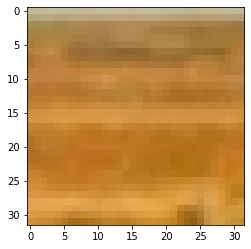

In [8]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.out = torch.nn.Linear(128, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=100, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 256]         123,136
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
           Linear-12                  [-1, 100]          12,900
Total params: 251,378
Trainable params: 251,378
Non-trainable params: 0
-------------------------------

In [13]:
num_epochs = 25
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/25]. Step [1/372]. Loss: 0.036. Acc: 0.000. Test acc: 0.008
Epoch [1/25]. Step [301/372]. Loss: 0.032. Acc: 0.081. Test acc: 0.107
Epoch [2/25]. Step [1/372]. Loss: 0.030. Acc: 0.180. Test acc: 0.120
Epoch [2/25]. Step [301/372]. Loss: 0.028. Acc: 0.142. Test acc: 0.133
Epoch [3/25]. Step [1/372]. Loss: 0.027. Acc: 0.156. Test acc: 0.148
Epoch [3/25]. Step [301/372]. Loss: 0.027. Acc: 0.182. Test acc: 0.136
Epoch [4/25]. Step [1/372]. Loss: 0.026. Acc: 0.203. Test acc: 0.152
Epoch [4/25]. Step [301/372]. Loss: 0.026. Acc: 0.206. Test acc: 0.157
Epoch [5/25]. Step [1/372]. Loss: 0.026. Acc: 0.234. Test acc: 0.172
Epoch [5/25]. Step [301/372]. Loss: 0.025. Acc: 0.218. Test acc: 0.182
Epoch [6/25]. Step [1/372]. Loss: 0.025. Acc: 0.242. Test acc: 0.188
Epoch [6/25]. Step [301/372]. Loss: 0.024. Acc: 0.232. Test acc: 0.206
Epoch [7/25]. Step [1/372]. Loss: 0.022. Acc: 0.312. Test acc: 0.198
Epoch [7/25]. Step [301/372]. Loss: 0.024. Acc: 0.245. Test acc: 0.194
Epoch [8/25]. Step [

Вопросы:

А. Что сложней в обучении :

    AlexNet
    LeNet
    VGG16

В. Почему сеть, которую выбрали, сложней обучать:

    Много параметров
    Затухающий градиент
    Очень глубокая
    Не удачные активационные функции
    Плохие данные

С. Зачем делаем перенос обучения:

    Это удобно
    Это экономит наше время обучения
    Это позволит решить задачи лучше

D. Определите размер карты признаков на выходе, если на вход слоя свертки пришел тензор 1х128х100х100, а сверточный слой имеет фильтр размера 3, шаг = 1 и использует заполнение 0

E. Определите размер карты признаков на выходе, если на вход слоя пуллинга пришел тензор 1х128х100х100, а сверточный слой имеет фильтр размера 2, шаг = 2 и использует заполнение 0

​



LeNet свёрточная нейросеть, использующая последовательность из трёх видов слоёв: convolution,pooling
и слои нелинейности. В AlexNet результаты вычислений LeNet масштабированы в гораздо более крупную нейросеть,
которая способна изучить намного более сложные объекты и их иерархии.В разработанных в Оксфорде VGG-сетях
в каждом свёрточном слое впервые применили фильтры 3х3 и объединили эти слои в последовательности свёрток.
Вместо применяемых в AlexNet фильтров 9х9 и 11х11 стали применять гораздо более мелкие фильтры, которых старались
избежать авторы LeNet. Но большим преимуществом VGG стала находка, что несколько свёрток 3х3, объединённых в 
последовательность, могут эмулировать более крупные свертки, например, 5х5 или 7х7.
Конечно, в большей степени ответ зависит от задачи. Для сложных задач нужна сложная сеть,
а для простых оптимальнее выбирать простые сетки.

Например VGG16, сложности - глубокая, проблема затухающего градиента, много параметров

Претренерованные сети очень удобно. Проект глубокого обучения можно относительно быстро реализовать, если взять 
предварительно обученную модель, которая использует знания, полученные во время обучения, и адаптировать
ее к поставленной задаче. Написать можно всего лишь три строки кода.

1х1х98х98

1х1х50х50